This notebook runs ECMWF's aifs-single-v1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

# 1. Install Required Packages and Imports

In [1]:
# Uncomment the lines below to install the required packages

# !pip install -q anemoi-inference[huggingface]==0.4.9 anemoi-models==0.3.1
# !pip install -q earthkit-regrid==0.4.0 ecmwf-opendata 
# !pip install -q flash_attn

In [2]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient

# 2. Retrieve Initial Conditions from ECMWF Open Data




### List of parameters to retrieve form ECMWF open data

In [3]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_SOIL =["vsw","sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1,2]

### Select a date

In [4]:
DATE = OpendataClient().latest()

In [5]:
print("Initial date is", DATE)

Initial date is 2025-02-24 00:00:00


### Get the data from the ECMWF Open Data API

In [6]:
def get_open_data(param, levelist=[]):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721,1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

### Get Input Fields

In [7]:
fields = {}

#### Add the single levels fields

In [8]:
fields.update(get_open_data(param=PARAM_SFC))

In [9]:
soil=get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS)

Soil parameters have been renamed since training this model, we need to rename to the original names

In [10]:
mapping = {'sot_1': 'stl1', 'sot_2': 'stl2',
           'vsw_1': 'swvl1','vsw_2': 'swvl2'}
for k,v in soil.items():
    fields[mapping[k]]=v

#### Add the pressure levels fields

In [11]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS))

#### Convert geopotential height into geopotential

In [12]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

### Create Initial State

In [18]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

### Download the Model's Checkpoint from Hugging Face & create a Runner

In [13]:
checkpoint = {"huggingface":"ecmwf/aifs-single-1.0"}

To reduce the memory usage of the model certain environment variables can be set, like the number of chunks of the model's mapper.
Please refer to:
- https://anemoi.readthedocs.io/projects/models/en/latest/modules/layers.html#anemoi-inference-num-chunks
- https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf

for more information. To do so, you can use the code below:
```
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True' 
os.environ['ANEMOI_INFERENCE_NUM_CHUNKS']='16'
```

In [16]:
runner = SimpleRunner(checkpoint, device="cuda")

**Note - changing the device from GPU to CPU**

- Running the transformer model used on the CPU is tricky, it depends on the FlashAttention library which only supports Nvidia and AMD GPUs, and is optimised for performance and memory usage
- In newer versions of anemoi-models, v0.4.2 and above, there is an option to switch off flash attention and uses Pytorchs Scaled Dot Product Attention (SDPA). The code snippet below shows how to overwrite a model from a checkpoint to use SDPA. Unfortunately it's not optimised for memory usage in the same way, leading to much greater memory usage. Please refer to https://github.com/ecmwf/anemoi-inference/issues/119 for more details 

#### Run the forecast

In [19]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)


😀 date=2025-02-24T06:00:00 latitudes=(542080,) longitudes=(542080,) fields=102

    q_50   shape=(542080,) min=2.20659e-06    max=3.33201e-06   
    t_1000 shape=(542080,) min=236.985        max=314.617       
    v_925  shape=(542080,) min=-38.6888       max=31.7169       
    z_850  shape=(542080,) min=9517.05        max=16554.1       
    swvl2  shape=(542080,) min=0              max=0.759204      
    tcc    shape=(542080,) min=0              max=1             


😀 date=2025-02-24T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=102

    q_50   shape=(542080,) min=2.16674e-06    max=3.32318e-06   
    t_1000 shape=(542080,) min=236.3          max=315.88        
    v_925  shape=(542080,) min=-44.4681       max=31.9381       
    z_850  shape=(542080,) min=9264.94        max=16019.2       
    swvl2  shape=(542080,) min=0              max=0.756526      
    tcc    shape=(542080,) min=0              max=1             



**Note** 
Due to the non-determinism of GPUs, users will be unable to exactly reproduce an official AIFS forecast when running AIFS Single themselves.
If you want to enforece determinism at GPU level, you can do so enforcing the following settings:

```
#First in your terminal
export CUBLAS_WORKSPACE_CONFIG=:4096:8

#And then before running inference:
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

```
Using the above approach will significantly increase runtime. Additionally, the input conditions come from open data, which we reproject from o1280 (the original projection of IFS initial conditions) to n320 (AIFS resolution) by first converting them to a 0.25-degree grid. In the operational setup, however, data is reprojected directly from o1280 to n320. This difference in reprojection methods may lead to variations in the resulting input conditions, causing minor differences in the forecast.

# 4. Inspect the generated forecast

#### Plot a field

In [1]:
# To be able to run the plotting section below you need to install additional dependencies

# !pip install -q matplotlib
# !pip install -q cartopy

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

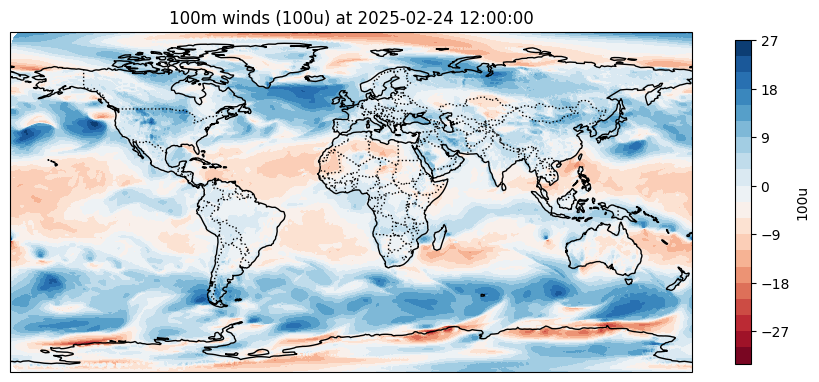

In [31]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["100u"]

fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="100u")

plt.title("100m winds (100u) at {}".format(state["date"]))
plt.show()